<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-dsercam/blob/main/RetoFinal/RetoFinal_Avance1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<font color="darkblue">Reto: Actividad Final</font>**
##**<font color="darkorange">  Regresiones y K means</font>**

###**Maestría en Inteligencia Artificial Aplicada**
###**Curso: Ciencia y analítica de datos**
####**Tecnológico de Monterrey**
#####**Prof: María de la Paz Rico Fernández**

###**<font color="darkgray">Nombre del estudiante: Dante Rodrigo Serna Camarillo</font>**
###**<font color="darkgray">Matrícula: A01182676</font>**


## <font color="darkorange"><b> Imports and installs

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 7.7 MB/s 
     |████████████████████████████████| 1.0 MB 42.8 MB/s 
     |████████████████████████████████| 1.7 MB 40.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 58.8 MB/s 
     |████████████████████████████████| 6.3 MB 47.3 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=472aa54cc78cc9989f353b83d835e7a234adcb24fc8f8a3b4a72e4ccae5dfe4d
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=96fbd1957ba2ea2fc92efb4b3912c5ebcbcd402faf7d2efe8ffd43f87d028bd8
  Stored in directory: /root/.

In [2]:
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
from shapely.geometry import Point # para definir cooredans que puedan ser usadas con geopy
import geopandas as gpd #para graficar en mapa
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## <font color="darkorange"><b> Carga de shape files para mexico

Obtenemos los shape files de Mexico, disponibles en un zip dentro del repo. Realizamos un unzip para cargar los datos en nuestro enterno de google colab.

In [5]:
!wget https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/raw/main/RetoFinal/mapa_mexico/mapa_mexico.zip
!unzip /content/mapa_mexico.zip

--2022-11-16 22:36:50--  https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/raw/main/RetoFinal/mapa_mexico/mapa_mexico.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/mapa_mexico/mapa_mexico.zip [following]
--2022-11-16 22:36:50--  https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/mapa_mexico/mapa_mexico.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11342120 (11M) [application/zip]
Saving to: ‘mapa_mexico.zip’

mapa_mexico.zip     100%[===================>]  10.82M

Leer el shape file con geopandas.

In [6]:
mx = gpd.read_file('mapa_mexico/').set_index('CLAVE')
        #.to_crs(epsg=4485)
mx.head()

,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
CLAVE,,,,,,
02004,Tijuana,Baja California,02,004,1122.661145,"POLYGON ((-117.09481 32.41141, -117.09481 32.4..."
02003,Tecate,Baja California,02,003,3670.991923,"POLYGON ((-116.73791 32.56703, -116.65926 32.5..."
02002,Mexicali,Baja California,02,002,13119.275713,"POLYGON ((-115.81505 32.64088, -115.70466 32.6..."
02005,Playas de Rosarito,Baja California,02,005,517.120801,"POLYGON ((-117.06254 32.34436, -117.06276 32.3..."
26055,San Luis Rio Colorado,Sonora,26,055,9033.770278,"POLYGON ((-114.96166 32.36465, -114.96239 32.3..."


## <font color="darkorange"><b> Fetch de data sets

In [7]:
#Permalinks a nuestros CSVs
#csvAguasSubterraneas  = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv"
csvAguasSuperficiales = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv"


In [8]:
#Config para ver todas las columnas de los dataframes
pd.set_option('display.max_columns', None)

In [9]:
#Fetch de datos
#dfUnprocessedSubterraneas  = pd.read_csv(csvAguasSubterraneas, skipinitialspace=True, skip_blank_lines=True, encoding = 'cp1252')
dfUnprocessedSuperficiales = pd.read_csv(csvAguasSuperficiales,  skipinitialspace=True, skip_blank_lines=True, encoding = 'cp1252')


In [10]:
print('--------'*10)
print("Dimensiones DataFrame aguas superficiales (sin procesar): ", dfUnprocessedSuperficiales.shape)
#print("Dimensiones DataFrame aguas subterraneas (sin procesar): ", dfUnprocessedSubterraneas.shape)
print('--------'*10)

--------------------------------------------------------------------------------
Dimensiones DataFrame aguas superficiales (sin procesar):  (4141, 55)
--------------------------------------------------------------------------------


## <font color="darkorange"><b> Preprocesamiento

In [ ]:
#print('Preview Aguas subterraneas:')
#dfUnprocessedSubterraneas.head(5)

<font color="darkblue" size=4> Para el proyecto elegí trabajar con la base de datos de aguas superficiales. 
Con el chainning de los métodos *isnull().values.any()* podemos comprobar que el dataframe tiene valores nulos.

In [ ]:
print('Preview Aguas Superficiales:')
dfUnprocessedSuperficiales.head(5)

Preview Aguas Superficiales:


,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,<1,No Toxico,NaN,NaN,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,22.87694,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,30,Excelente,NaN,NaN,96.2,Excelente,95.9,Excelente,95.5,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [ ]:
#Nuestro data set tiene datos faltanates
dfUnprocessedSuperficiales.isnull().values.any()

True

<font color="darkblue" size=4> Un detalle importante en este caso, hay pocas columnas que se interpretan como variables continuas, entre ellas latitud, longitud, periodo, además de otras cuatro columnas. Todas las demas han sido reconcoidas como valores de string/object.

In [ ]:
dfUnprocessedSuperficiales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

<font color="darkblue" size=4> Usando *describe(include='all')* podemos notar como muchas columnas son detectadas con un tipo object, ya que aunque los valores contenidos sean de naturaleza númerica, algunos son expresiones de tipo "mayor/menor que". Tambien podemos notar que las columnas *TOX_FIS_FON_15_UT, CALIDAD_TOX_FIS_FON_15, TOX_D_48_FON_UT, CALIDAD_TOX_D_48_FON* estan completamente vacías por lo que procederemos a eliminarlas.

In [ ]:
dfUnprocessedSuperficiales.describe(include='all')

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
count,3493,3493,3493,3493,3493,3492,3479,3493,3479,3493.000000,3493.000000,3493.0,2581,2581,2581,2581,3489,3489,2582,2582,2582,2582,904,904,1797,1797,1619,1619,487,487,946,946,1816,1816,1819,1819,762,762,0.0,0.0,1674,1674,0.0,0.0,3493,2226,3493,3493,3493,3493,3493,3493,3493,3493,3493
unique,3493,3481,13,32,755,521,1067,23,27,NaN,NaN,NaN,743,5,1211,5,1219,5,408,5,372,5,185,4,837,5,771,5,359,5,556,5,85,4,148,4,23,4,NaN,NaN,17,4,NaN,NaN,3,96,3,3,3,3,3,3,3,2,3
top,DLAGU8,ANTES DE LA CONFLUENCIA CON EL RIO ATOYAC,LERMA SANTIAGO PACIFICO,VERACRUZ DE IGNACIO DE LA LLAVE,ACAPULCO DE JUAREZ,YUCATAN (RESTO DE RH 32),OCEANO PACIFICO,LOTICO,RIO,NaN,NaN,NaN,<2,Excelente,<10,Contaminada,<10,Excelente,24000,Fuertemente contaminada,<3,Fuertemente contaminada,<3,Excelente,<10,Excelente,<10,Excelente,<10,Excelente,<10,Excelente,<1,No Toxico,<1,No Toxico,<1,No Toxico,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,"CF,E_COLI,",SI,SI,SI,NO,SI,ND,SI,SI,LOTICO
freq,1,3,709,326,60,101,139,1263,1478,NaN,NaN,NaN,1224,1330,559,790,880,1780,360,891,365,1054,464,709,110,769,15,853,14,236,35,409,1729,1729,1671,1671,738,738,NaN,NaN,1657,1657,NaN,NaN,1267,439,2319,1650,3104,1634,1453,2589,2958,3411,1772
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.359969,21.046992,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.122773,3.893696,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-117.124030,14.534910,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-103.882310,18.396070,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-99.795530,20.148980,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-96.860230,22.828930,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color="darkblue" size=4>  También detectamos que hay registros que no cuentan con valor en nuestra variable de salida "SEMAFORO", por lo que procedemos a generar un nuevo dataframe sin esos registros. Ese nuevo dataframe es el que usaremos para pre-procesar.
Nuestro dataset se reduce a 3,493 registros.

In [23]:
#Informacion sobre nuestra varaible de salida:
missingOutcome = dfUnprocessedSuperficiales['SEMAFORO'].isna().sum()
totalRecords   = dfUnprocessedSuperficiales.shape[0]

print('# de Registros sin valor en variable de salida: :', missingOutcome ,'(', round(((missingOutcome/totalRecords)*100),2),'%)')
print('# de Registros por categorizacion en semaforo:\n\n',dfUnprocessedSuperficiales.SEMAFORO.value_counts())

# de Registros sin valor en variable de salida: : 648 ( 15.65 %)
# de Registros por categorizacion en semaforo:

 Verde       1267
Amarillo    1135
Rojo        1091
Name: SEMAFORO, dtype: int64


In [24]:
#creamos nuevo dataset y eliminamos registros sin datos de salida.
dfForCleansingSuperficiales = dfUnprocessedSuperficiales.copy()
dfForCleansingSuperficiales = dfForCleansingSuperficiales[dfForCleansingSuperficiales['SEMAFORO'].notna()]
dfForCleansingSuperficiales.shape

(3493, 55)

<font color="darkblue" size=4> Eliminar las columnas que previamente habiamos identificado como completamente nulas.

In [25]:

dfForCleansingSuperficiales.drop('TOX_D_48_FON_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CALIDAD_TOX_D_48_FON', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TOX_FIS_FON_15_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CALIDAD_TOX_FIS_FON_15', inplace=True, axis=1)

<font color="darkblue" size=4> Después de eliminar los registros la distibución de los datos en nuestra clase queda de siguiente forma.

In [26]:
distribution = pd.DataFrame(dfForCleansingSuperficiales.SEMAFORO.value_counts())
totalRecords = distribution.sum()
distribution['DISTRIBUTION'] = distribution/totalRecords
distribution['SEMAFORO'] = distribution.index
distribution = distribution.reset_index(drop=True)
print(' --- DISTIRBUCION DE CLASES ---')
distribution

 --- DISTIRBUCION DE CLASES ---


,SEMAFORO,DISTRIBUTION
0,Verde,0.362725
1,Amarillo,0.324936
2,Rojo,0.312339


In [27]:
#Podemos tambien usar este for para validar si hay otras columnas vacias
columns = dfForCleansingSuperficiales.columns
for column in columns:
  print('[',column,'] column has [', dfForCleansingSuperficiales[column].isna().sum() ,'] missing values')

[ CLAVE ] column has [ 0 ] missing values
[ SITIO ] column has [ 0 ] missing values
[ ORGANISMO_DE_CUENCA ] column has [ 0 ] missing values
[ ESTADO ] column has [ 0 ] missing values
[ MUNICIPIO ] column has [ 0 ] missing values
[ CUENCA ] column has [ 1 ] missing values
[ CUERPO DE AGUA ] column has [ 14 ] missing values
[ TIPO ] column has [ 0 ] missing values
[ SUBTIPO ] column has [ 14 ] missing values
[ LONGITUD ] column has [ 0 ] missing values
[ LATITUD ] column has [ 0 ] missing values
[ PERIODO ] column has [ 0 ] missing values
[ DBO_mg/L ] column has [ 912 ] missing values
[ CALIDAD_DBO ] column has [ 912 ] missing values
[ DQO_mg/L ] column has [ 912 ] missing values
[ CALIDAD_DQO ] column has [ 912 ] missing values
[ SST_mg/L ] column has [ 4 ] missing values
[ CALIDAD_SST ] column has [ 4 ] missing values
[ COLI_FEC_NMP_100mL ] column has [ 911 ] missing values
[ CALIDAD_COLI_FEC ] column has [ 911 ] missing values
[ E_COLI_NMP_100mL ] column has [ 911 ] missing values
[ C

<font color="darkblue" size=4> Las Siguientes columnas tienen una natrualeza nominal, considero que la latitud y longitud del registro es suficiente para estimar el resto de estas caracterísitcas, por lo que no consideraremos estas columnas con la inteción de reducir la dimensionalidad de los datos, en cualquier caso se podría reasociar el dataset  a través del campo *clave* o incluso derviar la información a través de las coordenadas y una libreria de geocoordenadas

- SITIO
- ORGANISMO_DE_CUENCA
- ESTADO
- MUNICIPIO
- CUENCA
- CUERPO DE AGUA
- TIPO
- SUBTIPO

In [28]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def getAddress(row):
  return geolocator.reverse(str(row[0])+","+str(row[1]))

In [29]:
#dfForCleansingSuperficiales.drop('CLAVE', inplace=True, axis=1)
#eliminar las columnas que se refiera a la información geografica, que es mejor expresa en las coordenadas y pueded derivarse de las mismas.
dfForCleansingSuperficiales.drop('SITIO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('ORGANISMO_DE_CUENCA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('ESTADO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('MUNICIPIO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CUENCA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CUERPO DE AGUA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TIPO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('SUBTIPO', inplace=True, axis=1)

In [30]:
dfForCleansingSuperficiales.head(4)

,CLAVE,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,<1,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


<font color="darkblue" size=4> Dimensión del set ha cambiado a:

In [31]:
dfForCleansingSuperficiales.shape

(3493, 43)

<font color="darkblue" size=4> Vamos a remover símbolos de '<' y '>' sobre las columnas de muestras para después hacer un casting de las columnas hacía un tipo *float*.

In [45]:
dfForCleansingSuperficiales['DBO_mg/L'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['DQO_mg/L'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['SST_mg/L'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['COLI_FEC_NMP_100mL'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['E_COLI_NMP_100mL'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['ENTEROC_NMP_100mL'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_SUP'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_MED'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_FON'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_D_48_UT'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_V_15_UT'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_D_48_SUP_UT'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_FIS_SUP_15_UT'].replace({'>':''}, regex=True, inplace=True)


dfForCleansingSuperficiales['DBO_mg/L'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['DQO_mg/L'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['SST_mg/L'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['COLI_FEC_NMP_100mL'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['E_COLI_NMP_100mL'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['ENTEROC_NMP_100mL'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_SUP'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_MED'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_FON'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_D_48_UT'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_V_15_UT'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_D_48_SUP_UT'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_FIS_SUP_15_UT'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales.head(5)

,CLAVE,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,1,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,10,Excelente,NaN,NaN,NaN,NaN,3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,-109.89657,22.87694,2020.0,NaN,NaN,NaN,NaN,10,Excelente,NaN,NaN,NaN,NaN,30,Excelente,NaN,NaN,96.2,Excelente,95.9,Excelente,95.5,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [46]:
#Cambiamos el data type de las columnas.

dfForCleansingSuperficiales = dfForCleansingSuperficiales.astype({'DBO_mg/L': float, 'DQO_mg/L': float,
                                                                    'SST_mg/L': float, 'COLI_FEC_NMP_100mL': float,
                                                                    'E_COLI_NMP_100mL': float, 'ENTEROC_NMP_100mL': float,
                                                                    'OD_PORC': float, 'OD_PORC_SUP': float,
                                                                    'OD_PORC_MED': float, 'OD_PORC_FON': float,
                                                                    'TOX_D_48_UT': float, 'TOX_V_15_UT': float,
                                                                    'TOX_D_48_SUP_UT': float, 'TOX_FIS_SUP_15_UT': float
                                                                    })

In [47]:
#comprobamos que se han cambiado los data types
dfForCleansingSuperficiales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   LONGITUD                3493 non-null   float64
 2   LATITUD                 3493 non-null   float64
 3   PERIODO                 3493 non-null   float64
 4   DBO_mg/L                2581 non-null   float64
 5   CALIDAD_DBO             2581 non-null   object 
 6   DQO_mg/L                2581 non-null   float64
 7   CALIDAD_DQO             2581 non-null   object 
 8   SST_mg/L                3489 non-null   float64
 9   CALIDAD_SST             3489 non-null   object 
 10  COLI_FEC_NMP_100mL      2582 non-null   float64
 11  CALIDAD_COLI_FEC        2582 non-null   object 
 12  E_COLI_NMP_100mL        2582 non-null   float64
 13  CALIDAD_E_COLI          2582 non-null   object 
 14  ENTEROC_NMP_100mL       904 non-null    

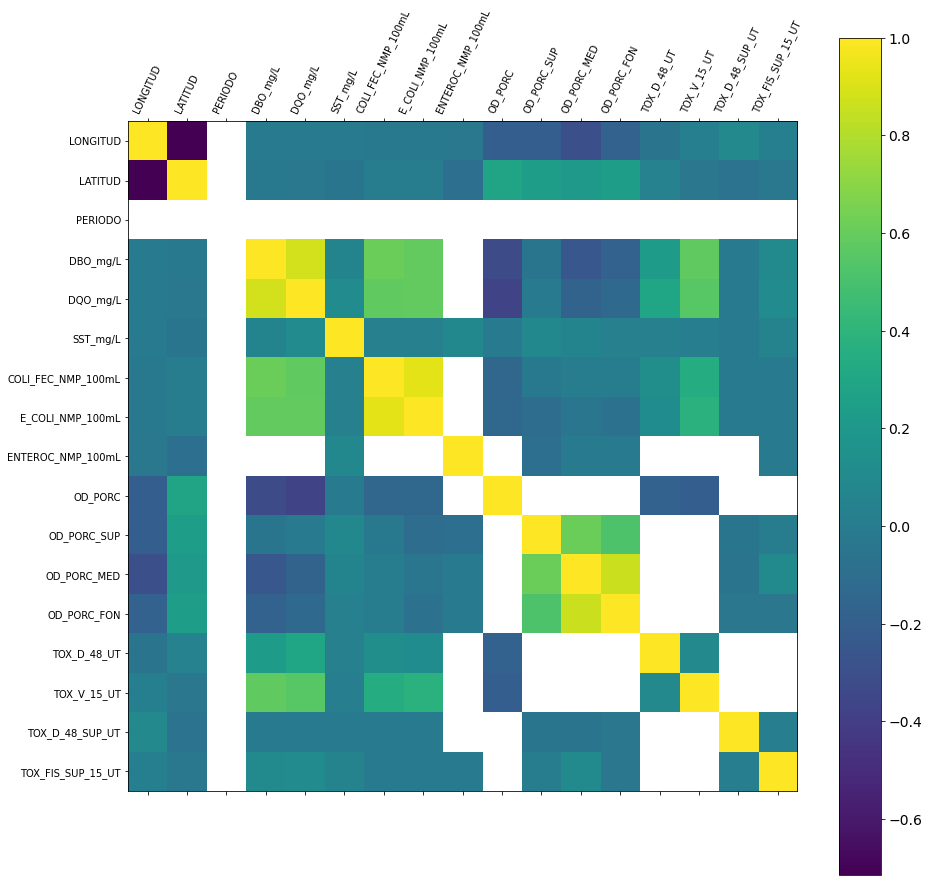

In [59]:
f = plt.figure(figsize=(15, 15))
plt.matshow(dfForCleansingSuperficiales.corr(), fignum=f.number)
plt.xticks(range(dfForCleansingSuperficiales.select_dtypes(['number']).shape[1]), dfForCleansingSuperficiales.select_dtypes(['number']).columns, fontsize=10, rotation=65)
plt.yticks(range(dfForCleansingSuperficiales.select_dtypes(['number']).shape[1]), dfForCleansingSuperficiales.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

<font color="darkblue" size=4> <b> Nota Importante: </b>
<br> Las siguientes columnas tienen un correlación directa, en cada par una columna se refiere al valor o lectura de una métrica, y la segunda columna se refiere a la categorización de dicho valor en una escala definida. Por lo tanto, ambas columnas refieren la misma información. <br>
Con la intención de dismunir la dimensionalidad generaremos dos datasets para posteriromente medir el rendimiento del modelo. En cada uno de ellos elimaneremos ya sea las columnas de los valores de la muestra o las columnas referentes a su categoría.
El objetivo sería reducir la complejidad para la convergencia y procesamiento.

| Variable con medición  | Variable categórica |
|---|---|
| DBO_mg/L | CALIDAD_DBO |
| DQO_mg/L | CALIDAD_DQO |
| SST_mg/L | CALIDAD_SST |
| COLI_FEC_NMP_100mL | CALIDAD_COLI_FEC |
| E_COLI_NMP_100mL | CALIDAD_E_COLI |
| ENTEROC_NMP_100mL | CALIDAD_ENTEROC |
| OD_PORC  | CALIDAD_OD_PORC|
| OD_PORC_SUP | CALIDAD_OD_PORC_SUP |
| OD_PORC_MED | CALIDAD_OD_PORC_MED |
| OD_PORC_FON | CALIDAD_OD_PORC_FON |
| TOX_D_48_UT | CALIDAD_TOX_D_48 |
| TOX_V_15_UT | CALIDAD_TOX_V_15 |
| TOX_D_48_SUP_UT | CALIDAD_TOX_D_48_SUP |
| TOX_D_48_FON_UT | CALIDAD_TOX_D_48_FON |
| TOX_FIS_SUP_15_UT | CALIDAD_TOX_FIS_SUP_15 |
| TOX_FIS_FON_15_UT | CALIDAD_TOX_FIS_FON_15 |

In [ ]:
dfSuperficialesCategoricas = dfForCleansingSuperficiales.copy()
dfSuperficialesCategoricas.drop('DBO_mg/L', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('DQO_mg/L', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('SST_mg/L', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('COLI_FEC_NMP_100mL', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('E_COLI_NMP_100mL', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('ENTEROC_NMP_100mL', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('OD_PORC', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('OD_PORC_SUP', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('OD_PORC_MED', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('OD_PORC_FON', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('TOX_D_48_UT', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('TOX_V_15_UT', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('TOX_D_48_SUP_UT', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('TOX_FIS_SUP_15_UT', inplace=True, axis=1)


In [ ]:
dfForCleansingSuperficiales.dtypes

CLAVE                      object
LONGITUD                  float64
LATITUD                   float64
PERIODO                   float64
CALIDAD_DBO                object
CALIDAD_DQO                object
CALIDAD_SST                object
CALIDAD_COLI_FEC           object
CALIDAD_E_COLI             object
CALIDAD_ENTEROC            object
CALIDAD_OD_PORC            object
CALIDAD_OD_PORC_SUP        object
CALIDAD_OD_PORC_MED        object
CALIDAD_OD_PORC_FON        object
CALIDAD_TOX_D_48           object
CALIDAD_TOX_V_15           object
CALIDAD TOX_D_48_SUP       object
CALIDAD_TOX_FIS_SUP_15     object
SEMAFORO                   object
CONTAMINANTES              object
CUMPLE_CON_DBO             object
CUMPLE_CON_DQO             object
CUMPLE_CON_SST             object
CUMPLE_CON_CF              object
CUMPLE_CON_E_COLI          object
CUMPLE_CON_ENTEROC         object
CUMPLE_CON_OD              object
CUMPLE_CON_TOX             object
GRUPO                      object
dtype: object

In [ ]:
dfForCleansingSuperficiales.head(4)

,CLAVE,LONGITUD,LATITUD,PERIODO,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,2020.0,Buena calidad,Contaminada,Excelente,Contaminada,Excelente,NaN,NaN,Aceptable,NaN,NaN,NaN,NaN,No Toxico,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,2020.0,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,2020.0,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,2020.0,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,NaN,NaN,Excelente,NaN,NaN,NaN,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [ ]:
#Validar si hay columnas totlamente vacias, en ese caso las elimminaremos
columns = dfForCleansingSuperficiales.columns
for column in columns:
  print('[',column,'] column has [', dfForCleansingSuperficiales[column].isna().sum() ,'] missing values')

[ CLAVE ] column has [ 0 ] missing values
[ LONGITUD ] column has [ 0 ] missing values
[ LATITUD ] column has [ 0 ] missing values
[ PERIODO ] column has [ 0 ] missing values
[ CALIDAD_DBO ] column has [ 912 ] missing values
[ CALIDAD_DQO ] column has [ 912 ] missing values
[ CALIDAD_SST ] column has [ 4 ] missing values
[ CALIDAD_COLI_FEC ] column has [ 911 ] missing values
[ CALIDAD_E_COLI ] column has [ 911 ] missing values
[ CALIDAD_ENTEROC ] column has [ 2589 ] missing values
[ CALIDAD_OD_PORC ] column has [ 1696 ] missing values
[ CALIDAD_OD_PORC_SUP ] column has [ 1874 ] missing values
[ CALIDAD_OD_PORC_MED ] column has [ 3006 ] missing values
[ CALIDAD_OD_PORC_FON ] column has [ 2547 ] missing values
[ CALIDAD_TOX_D_48 ] column has [ 1677 ] missing values
[ CALIDAD_TOX_V_15 ] column has [ 1674 ] missing values
[ CALIDAD TOX_D_48_SUP ] column has [ 2731 ] missing values
[ CALIDAD_TOX_FIS_SUP_15 ] column has [ 1819 ] missing values
[ SEMAFORO ] column has [ 0 ] missing values
[ C

Vamos a definir un imputer para ser usado posteriormente en un pipeline junto a algun modelo. Sin embargo en este momento imputaremos los valores directamente con fillna() , poblando los valores faltantes con una nueva categoria de "sin medida".

In [ ]:
#vamos a imputar los valores faltantes en las variables categoricos
columnasCategoricas = ['CALIDAD_DBO','CALIDAD_DQO','CALIDAD_SST','CALIDAD_COLI_FEC','CALIDAD_E_COLI','CALIDAD_ENTEROC','CALIDAD_OD_PORC',
                       'CALIDAD_OD_PORC_SUP','CALIDAD_OD_PORC_MED','CALIDAD_OD_PORC_FON','CALIDAD_TOX_D_48','CALIDAD_TOX_V_15','CALIDAD TOX_D_48_SUP',
                       'CALIDAD_TOX_FIS_SUP_15','CONTAMINANTES']
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Sin medida')

In [ ]:
#definicion del column transformer
general_transform = ColumnTransformer([("imputerCat", imputer, columnasCategoricas)])

In [ ]:
dfForCleansingSuperficiales['CALIDAD_DBO'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_DQO'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_SST'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_COLI_FEC'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_E_COLI'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_ENTEROC'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_OD_PORC'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_OD_PORC_SUP'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_OD_PORC_MED'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_OD_PORC_FON'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_TOX_D_48'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_TOX_V_15'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD TOX_D_48_SUP'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CALIDAD_TOX_FIS_SUP_15'].fillna('Sin medida', inplace = True)
dfForCleansingSuperficiales['CONTAMINANTES'].fillna('Sin medida', inplace = True)

In [ ]:
#aplicar el transformer
pipeline = Pipeline([("transformer", general_transform)])
pipeline.fit_transform(dfForCleansingSuperficiales)

array([['Buena calidad', 'Contaminada', 'Excelente', ..., 'No Toxico',
        'No Toxico', 'DQO,CF,'],
       ['Sin medida', 'Sin medida', 'Excelente', ..., 'Sin medida',
        'No Toxico', 'Sin medida'],
       ['Sin medida', 'Sin medida', 'Excelente', ..., 'Sin medida',
        'No Toxico', 'Sin medida'],
       ...,
       ['Buena calidad', 'Contaminada', 'Buena calidad', ...,
        'Sin medida', 'Sin medida', 'DQO,'],
       ['Excelente', 'Aceptable', 'Buena calidad', ..., 'Sin medida',
        'Sin medida', 'CF,'],
       ['Excelente', 'Aceptable', 'Buena calidad', ..., 'Sin medida',
        'Sin medida', 'CF,']], dtype=object)

In [ ]:
#imputación ok.
dfForCleansingSuperficiales.head(5)

,CLAVE,LONGITUD,LATITUD,PERIODO,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,2020.0,Buena calidad,Contaminada,Excelente,Contaminada,Excelente,Sin medida,Sin medida,Aceptable,Sin medida,Sin medida,Sin medida,Sin medida,No Toxico,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,2020.0,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Excelente,Excelente,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,2020.0,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Excelente,Excelente,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,2020.0,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,-109.89657,22.87694,2020.0,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Excelente,Excelente,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [ ]:
columns = dfForCleansingSuperficiales.columns
for column in columns:
  print('\n\n[',column,'] column has [\n', dfForCleansingSuperficiales[column].value_counts() ,'\n] as values counts')



[ CLAVE ] column has [
 DLAGU8         1
OCGNO3515      1
OCGNO3504      1
OCGNO3505      1
OCGNO3506      1
              ..
DLPUE2006      1
DLPUE2007      1
DLPUE2008      1
DLPUE2009      1
OCRBR5210M1    1
Name: CLAVE, Length: 3493, dtype: int64 
] as values counts


[ LONGITUD ] column has [
 -97.68530     2
-105.25951    2
-95.02570     2
-101.84492    2
-92.32058     2
             ..
-97.64122     1
-97.70254     1
-97.67252     1
-97.59411     1
-99.52572     1
Name: LONGITUD, Length: 3486, dtype: int64 
] as values counts


[ LATITUD ] column has [
 19.32619    2
14.61567    2
20.17025    2
19.32413    2
20.99406    2
           ..
19.95836    1
20.40963    1
20.44572    1
20.50123    1
27.51697    1
Name: LATITUD, Length: 3485, dtype: int64 
] as values counts


[ PERIODO ] column has [
 2020.0    3493
Name: PERIODO, dtype: int64 
] as values counts


[ CALIDAD_DBO ] column has [
 Excelente                  1330
Sin medida                  912
Aceptable                   

Con este análisis también podemos ver que el atributo de periodo solo tiene un valor, por lo que no aporta información al modelo, procedemos a eliminar esa columna.

In [ ]:
dfForCleansingSuperficiales.drop('PERIODO', inplace=True, axis=1)

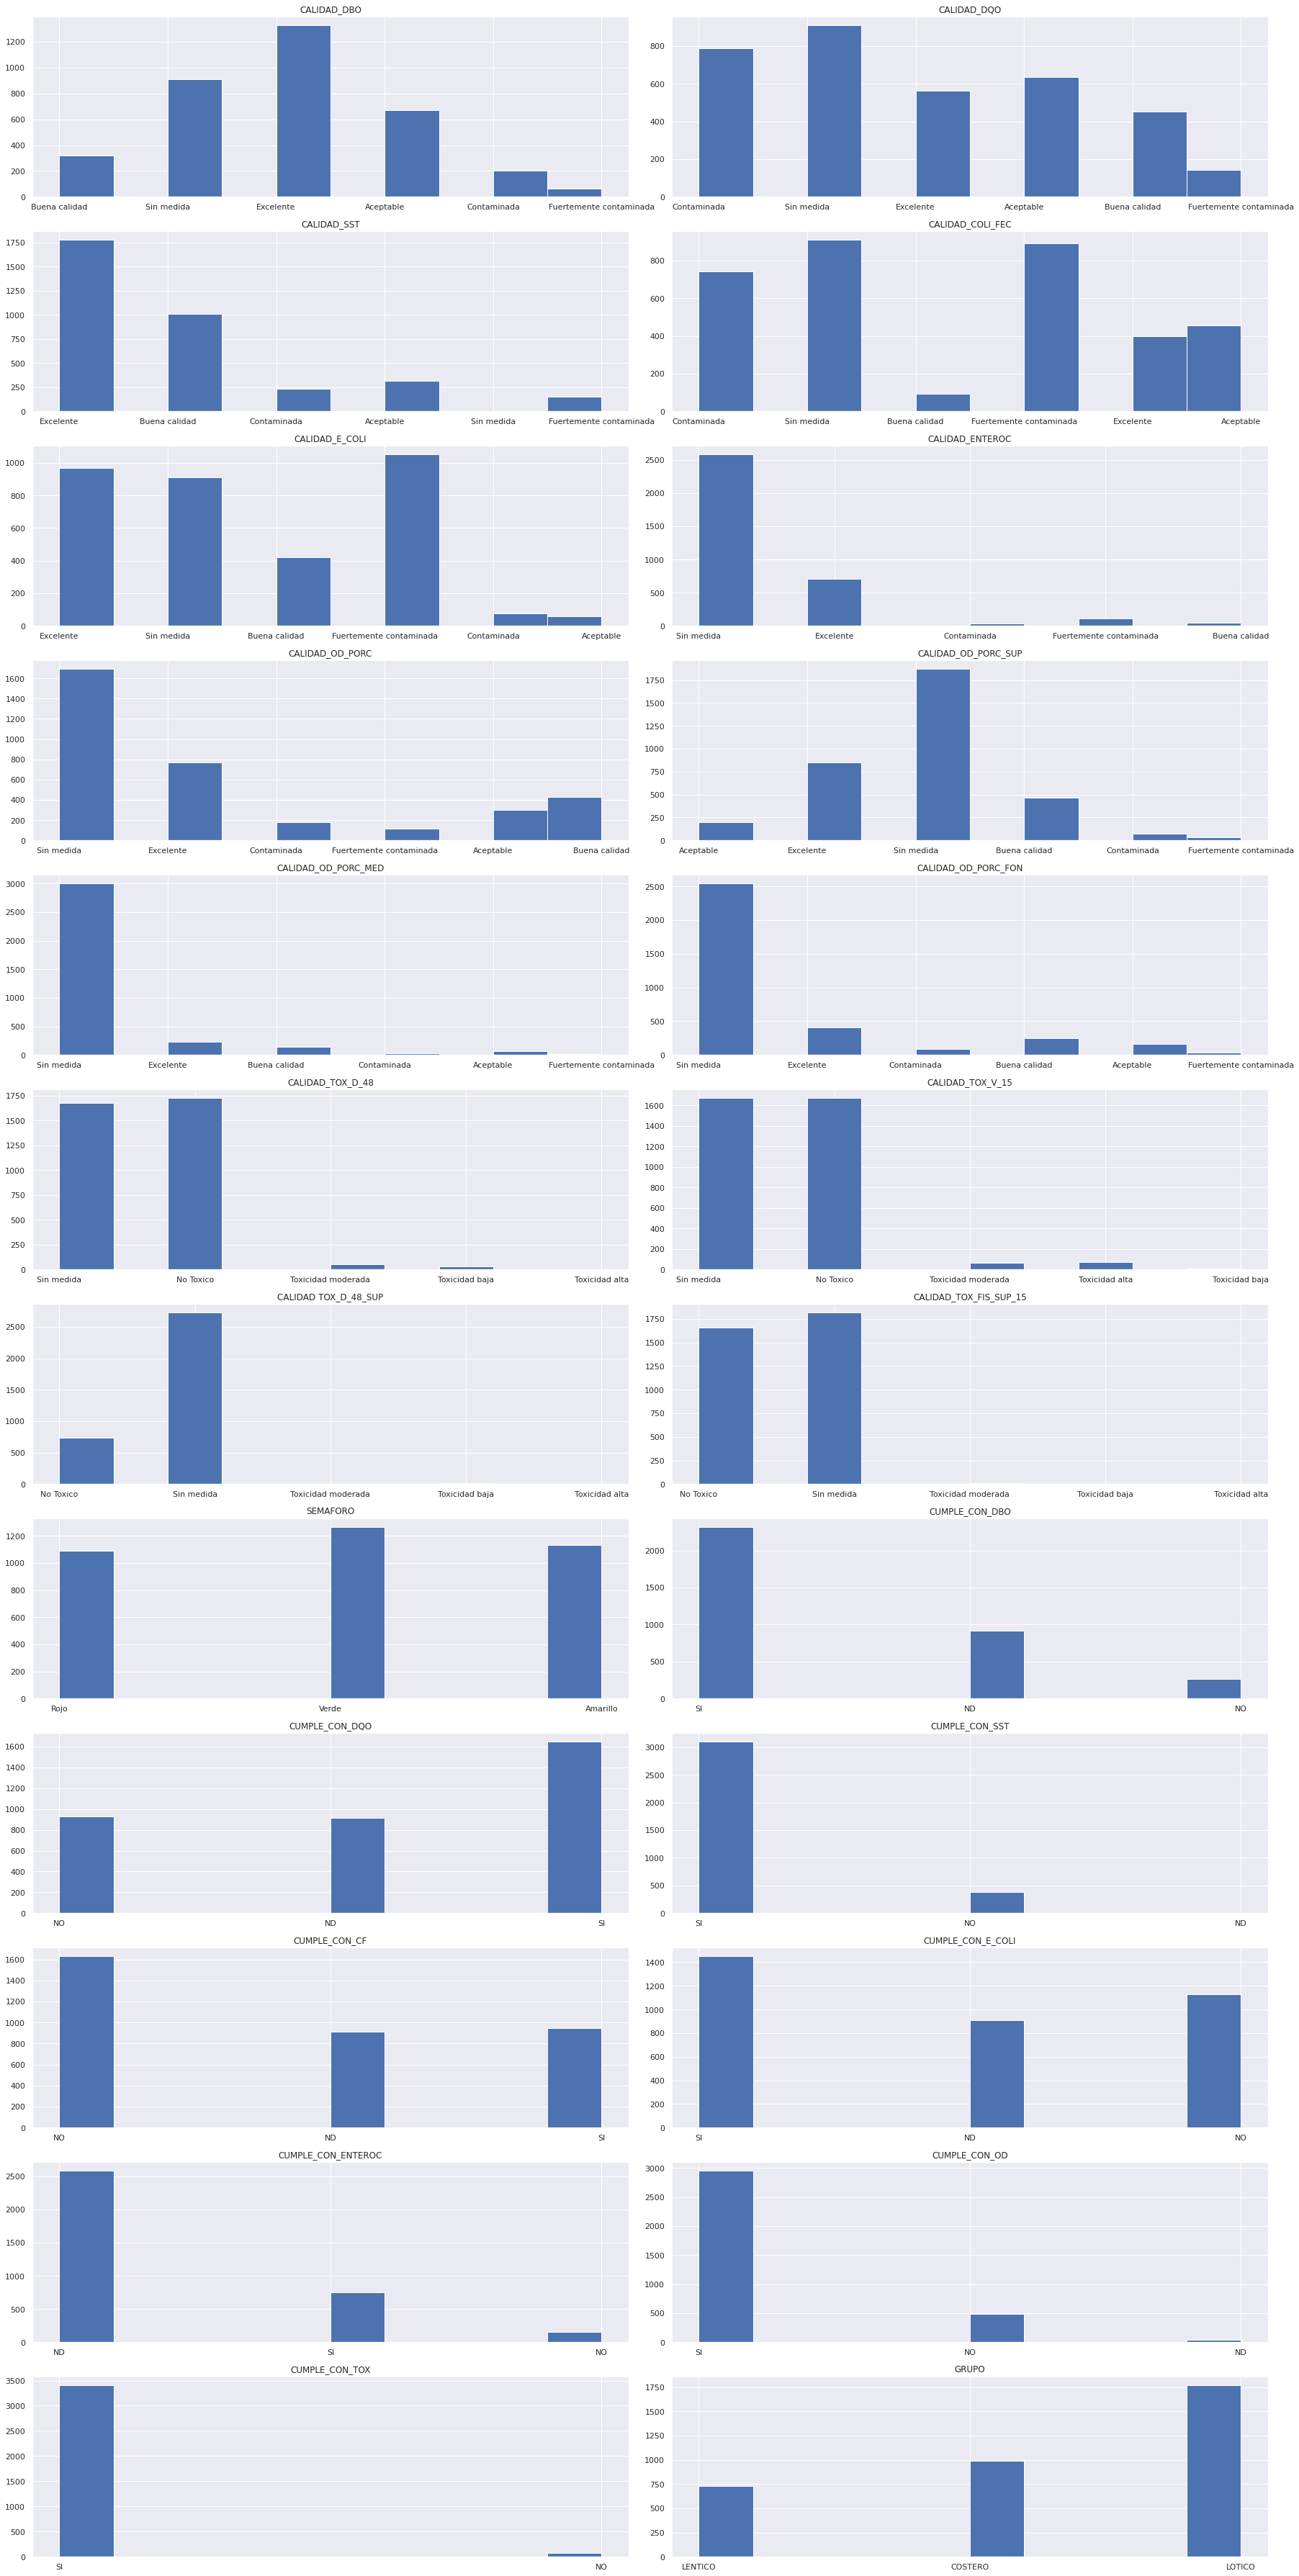

In [ ]:
sns.set(rc={'figure.figsize':(25,50)})
fig, axes = plt.subplots(12,2)
fig.tight_layout(pad=2.0)

columns = [ 'CALIDAD_DBO', 'CALIDAD_DQO', 'CALIDAD_SST', 'CALIDAD_COLI_FEC', 'CALIDAD_E_COLI', 'CALIDAD_ENTEROC',
       'CALIDAD_OD_PORC', 'CALIDAD_OD_PORC_SUP', 'CALIDAD_OD_PORC_MED','CALIDAD_OD_PORC_FON', 'CALIDAD_TOX_D_48', 'CALIDAD_TOX_V_15',
       'CALIDAD TOX_D_48_SUP', 'CALIDAD_TOX_FIS_SUP_15', 'SEMAFORO', 'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO',
       'CUMPLE_CON_SST','CUMPLE_CON_CF', 'CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC','CUMPLE_CON_OD', 'CUMPLE_CON_TOX',
       'GRUPO']
counter = 1
for column in columns:
  plt.subplot(12,2,counter)
  plt.title(column) 
  counter = counter+1
  plt.hist(dfForCleansingSuperficiales[column])

plt.show()




### Construccion de data frames de longitud y latitud para graficar

In [ ]:
#definimos nuestro dataframe de longitudes y latitudes para aguas superficiales
superficialesLatLon = dfForCleansingSuperficiales.copy()
superficialesLatLon = superficialesLatLon[['CLAVE','LATITUD','LONGITUD','SEMAFORO']]
superficialesLatLon["Coordinates"] = list(zip(superficialesLatLon.LONGITUD, superficialesLatLon.LATITUD))
superficialesLatLon["Coordinates"] = superficialesLatLon["Coordinates"].apply(Point)
#definimos nuestro dataframe de longitudes y latitudes para aguas superficiales
#subterraneasLatLon = dfUnprocessedSubterraneas.copy()
#subterraneasLatLon = subterraneasLatLon[['CLAVE','LATITUD','LONGITUD','SEMAFORO']]
#subterraneasLatLon["Coordinates"] = list(zip(subterraneasLatLon.LONGITUD, subterraneasLatLon.LATITUD))
#subterraneasLatLon["Coordinates"] = subterraneasLatLon["Coordinates"].apply(Point)

## <font color='red'>Definir componentes para grafica del pais</font>


In [ ]:
def graphCuerposDeAgua(main_clustering, main_shadow, red_clustering, yellow_clustering, green_clustering, cuerposDeAgua):
  #calculate Kmeans
  #df por semaforo
  dfAmarillo = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Amarillo'].copy()
  dfAmarillo = dfAmarillo[['LATITUD','LONGITUD']]
  dfRojo     = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Rojo'].copy()
  dfRojo     = dfRojo[['LATITUD','LONGITUD']]
  dfVerde    = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Verde'].copy()
  dfVerde    = dfVerde[['LATITUD','LONGITUD']]
  dfFull     = cuerposDeAgua[['LATITUD','LONGITUD']].copy()
  
  kmeans = KMeans(n_clusters=main_clustering)
  #obtener clusters generales
  kmeans.fit(dfFull)
  full_kmeans = kmeans.predict(dfFull)
  full_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfFull = pd.DataFrame(full_centers)
  dfFull.columns = ["latitude","longitude"]
  dfFull["Coordinates"] = list(zip(dfFull.longitude, dfFull.latitude))
  dfFull["Coordinates"] = dfFull["Coordinates"].apply(Point)
  gdfFull = gpd.GeoDataFrame(dfFull, geometry="Coordinates")


  #obtener amarillos
  kmeans = KMeans(n_clusters=yellow_clustering)
  kmeans.fit(dfAmarillo)
  yellow_kmeans = kmeans.predict(dfAmarillo)
  yellow_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfYellow = pd.DataFrame(yellow_centers)
  dfYellow.columns = ["latitude","longitude"]
  dfYellow["Coordinates"] = list(zip(dfYellow.longitude, dfYellow.latitude))
  dfYellow["Coordinates"] = dfYellow["Coordinates"].apply(Point)
  gdfYellowKmeans = gpd.GeoDataFrame(dfYellow, geometry="Coordinates")

  #obtener verdes
  kmeans = KMeans(n_clusters=green_clustering)
  kmeans.fit(dfVerde)
  red_kmeans = kmeans.predict(dfVerde)
  green_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfGreen  = pd.DataFrame(green_centers)
  dfGreen.columns = ["latitude","longitude"]
  dfGreen["Coordinates"] = list(zip(dfGreen.longitude, dfGreen.latitude))
  dfGreen["Coordinates"] = dfGreen["Coordinates"].apply(Point)
  gdfGreenKmeans = gpd.GeoDataFrame(dfGreen, geometry="Coordinates")
  
  #obtener rojos
  kmeans = KMeans(n_clusters=red_clustering)
  kmeans.fit(dfRojo)
  green_kmeans = kmeans.predict(dfRojo)
  red_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfRed    = pd.DataFrame(red_centers)
  dfRed.columns = ["latitude","longitude"]
  dfRed["Coordinates"] = list(zip(dfRed.longitude, dfRed.latitude))
  dfRed["Coordinates"] = dfRed["Coordinates"].apply(Point)
  gdfRedKmeans = gpd.GeoDataFrame(dfRed, geometry="Coordinates")

  ###dfKmeans = pd.DataFrame(centers)
  ###dfKmeans.columns = ["latitude","longitude"]
  ###dfKmeans["Coordinates"] = list(zip(dfKmeans.longitude, dfKmeans.latitude))
  ###dfKmeans["Coordinates"] = dfKmeans["Coordinates"].apply(Point)
  #prepare traget stores data.
  dfCuerposDeAgua = cuerposDeAgua.copy()
  dfCuerposDeAgua["Coordinates"] = list(zip(dfCuerposDeAgua.LONGITUD, dfCuerposDeAgua.LATITUD))
  dfCuerposDeAgua["Coordinates"] = dfCuerposDeAgua["Coordinates"].apply(Point)
  gdfCuerposDeAgua = gpd.GeoDataFrame(dfCuerposDeAgua, geometry="Coordinates")
  #gdfKmeans = gpd.GeoDataFrame(dfKmeans, geometry="Coordinates")
  #gTargetStores = gpd.GeoDataFrame(dfStores, geometry="Coordinates")
  

  #grafica de cuerpos de agua.
  fig, ax = plt.subplots(figsize=(20,14))

  ax.set_xlabel('longitude')
  ax.set_ylabel('latitude')

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  
  #MAPA MEXICO
  mx.plot(ax=ax, k=5, alpha=0.7)
  #CUERPOS DE AGUA
  #semaforo color map
  semaforo_cmap = {'Amarillo': 'yellow', 'Verde': 'limegreen', 'Rojo' : 'red'}
  cmap_s = colors.ListedColormap([semaforo_cmap[b] for b in gdfCuerposDeAgua.SEMAFORO.unique()])
  gdfCuerposDeAgua.plot(ax=ax, alpha = 1.0, column='SEMAFORO', cmap=cmap_s, legend=True)


  fig2, ax2 = plt.subplots(figsize=(20,14))
  #GRAFICA DE KMEANS
  mx.plot(ax=ax2, k=5, alpha=0.5)
  gdfRedKmeans.plot(ax=ax2, color='red', alpha =1.0, markersize=250, marker="X", legend=True, label='Red clusters')
  gdfYellowKmeans.plot(ax=ax2, color='yellow', alpha =1.0, markersize=250, marker="H", legend=True, label='Yellow clusters')
  gdfGreenKmeans.plot(ax=ax2, color='limegreen', alpha =1.0, markersize=250, marker="o", legend=True, label='Green clusters')
  gdfFull.plot(ax=ax2, color='purple', alpha =0.3, markersize=main_shadow, marker="o", legend=True, label='K-means clusters')
  #ax2.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., markerscale=.3)
  lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=15,facecolor='lightgray')
  lgnd.legendHandles[0]._sizes = [30]
  lgnd.legendHandles[1]._sizes = [30]
  lgnd.legendHandles[2]._sizes = [30]
  lgnd.legendHandles[3]._sizes = [30]
  

In [ ]:
#from pyproj import Proj, transform, CRS
#proj_4485 = CRS("epsg:4485")


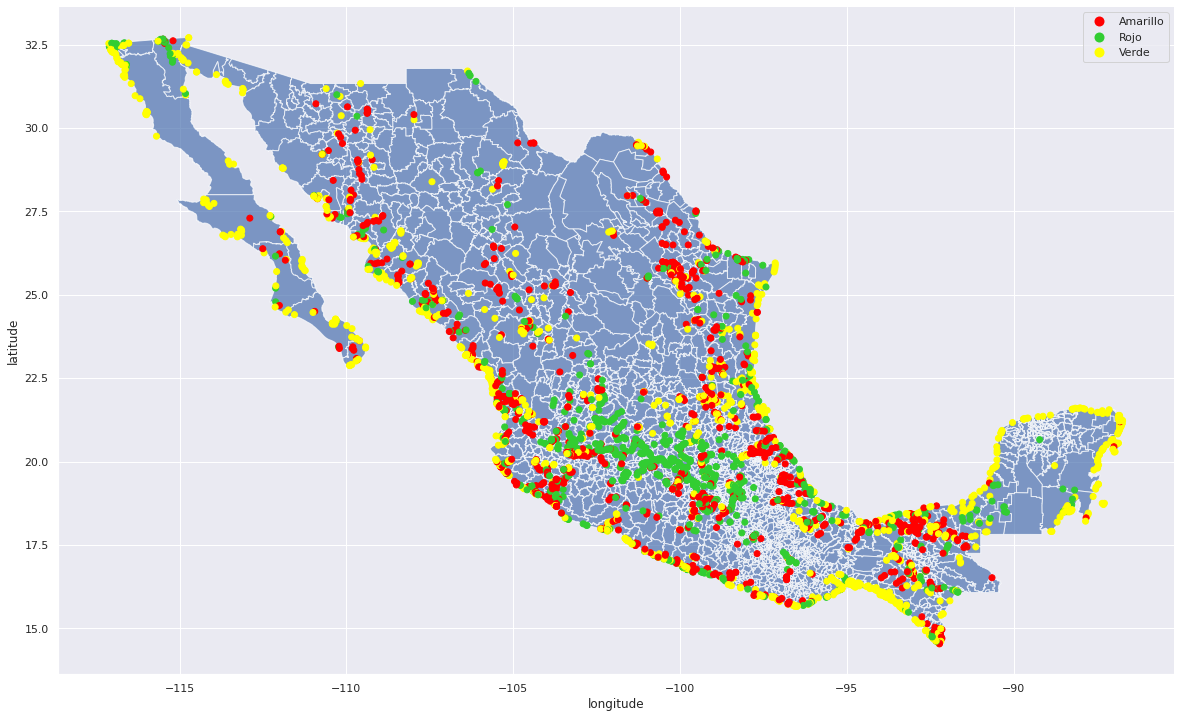

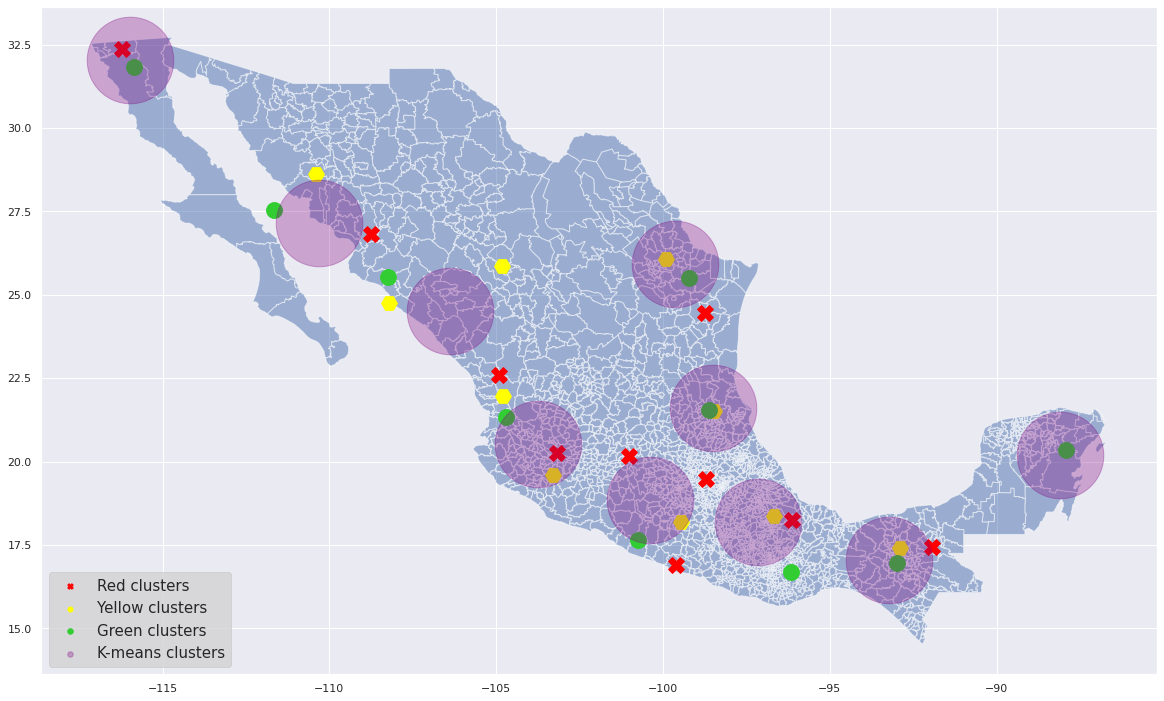

In [ ]:
graphCuerposDeAgua(10, 7500, 10, 10, 10, superficialesLatLon)

Vamos a utilizar metodo de elbow y silhoutte para determinar cuantos clusters seria apropiado usar.

In [ ]:

def graphSilhouetteScoreInRange(lowerLimit,upperLimit,storesLatLon):
  range_n_clusters = range(lowerLimit,upperLimit)
  silhouette_avg = []
  for num_clusters in range_n_clusters:
  
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(storesLatLon)
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(storesLatLon, cluster_labels))

  plt.subplots(figsize=(20,14))
  plt.plot(range_n_clusters,silhouette_avg,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Silhouette score') 
  plt.title('Silhouette analysis For Optimal k')
  plt.show()

In [ ]:
def graphElbowKmeansInRange(lowerLimit,upperLimit,storesLatLon):
  Sum_of_squared_distances = []
  K = range(lowerLimit,upperLimit)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(storesLatLon)
    Sum_of_squared_distances.append(kmeans.inertia_)
  plt.subplots(figsize=(20,14))
  plt.plot(K,Sum_of_squared_distances,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Sum of squared distances/Inertia') 
  plt.title('Elbow Method For Optimal k')
  plt.show()

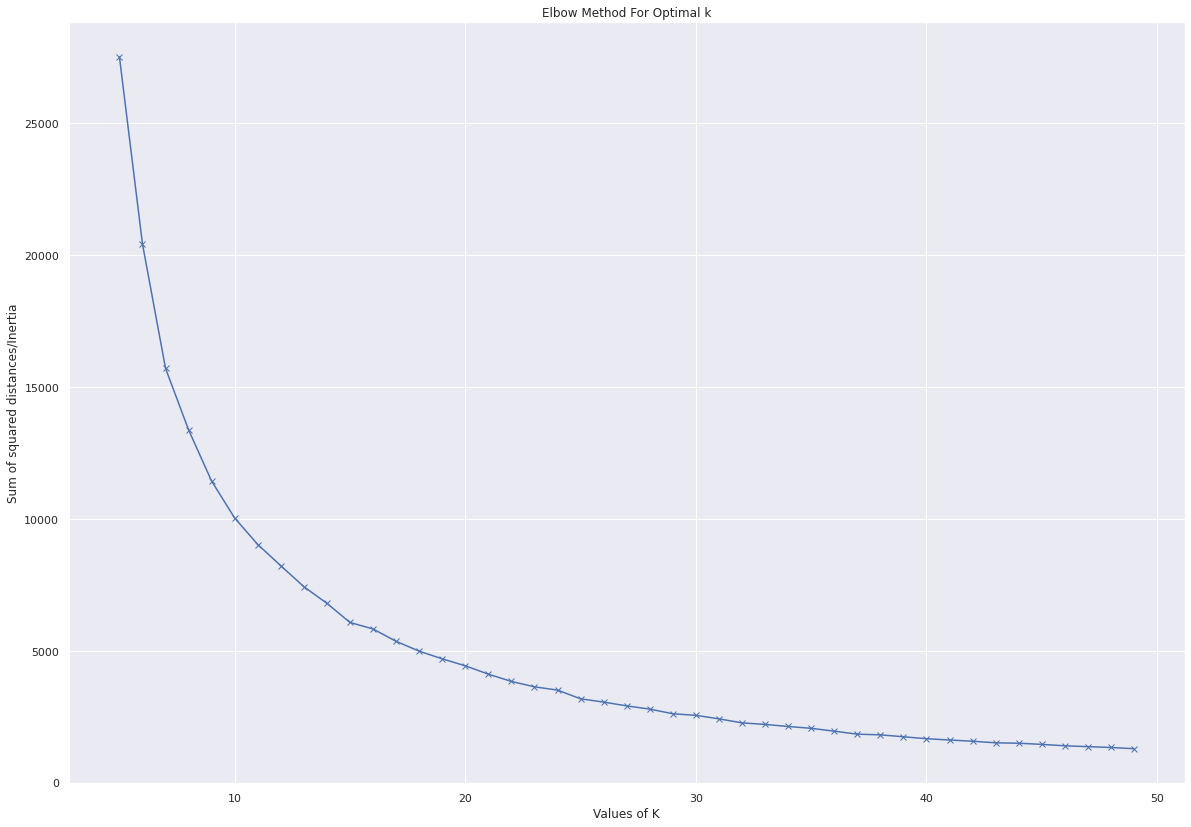

In [ ]:
graphElbowKmeansInRange(5,50,superficialesLatLon[['LATITUD','LONGITUD']])

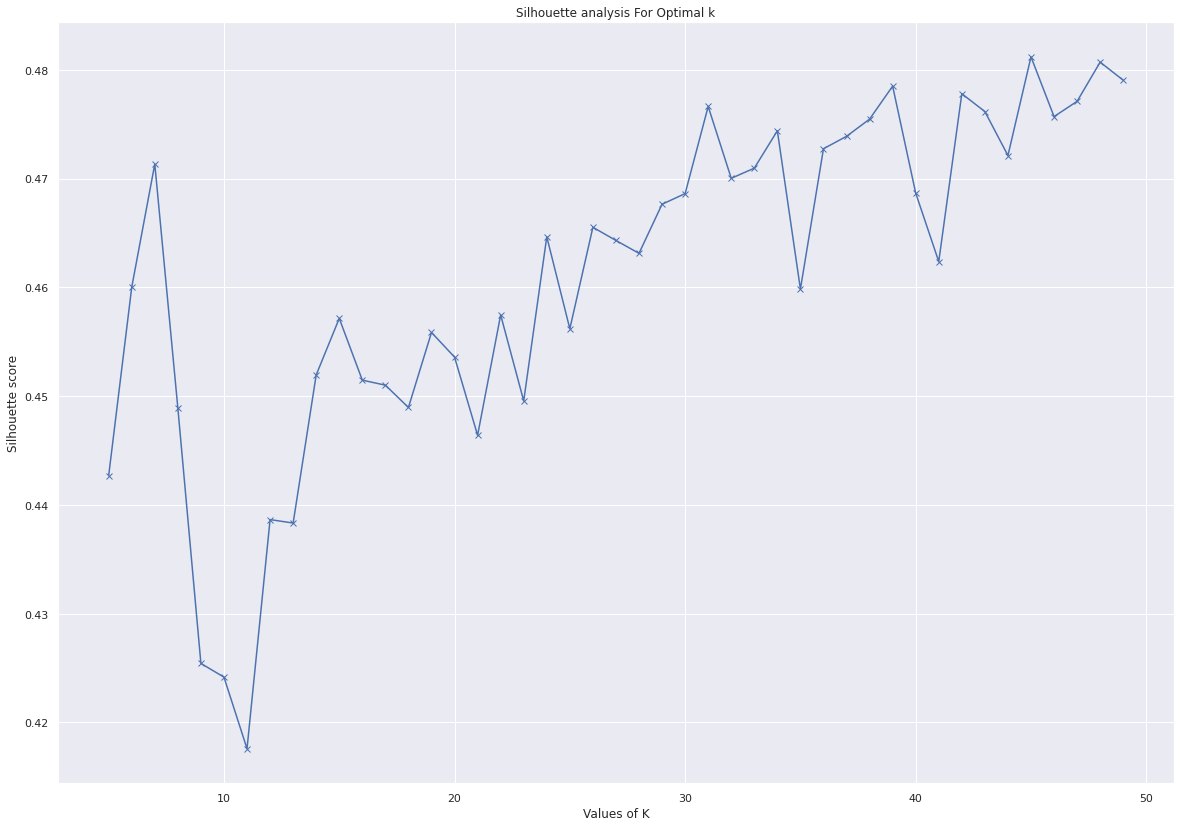

In [ ]:
graphSilhouetteScoreInRange(5,50,superficialesLatLon[['LATITUD','LONGITUD']])

Conforme a las graficas, usaremos 30 clusters. Nos podemos dar cuenta que aun con 30 clusters, existen muestras de mas de un tipo en dicho cluster, por lo que aun se necesitarian mas clusters para lograr una mejor segmentación.

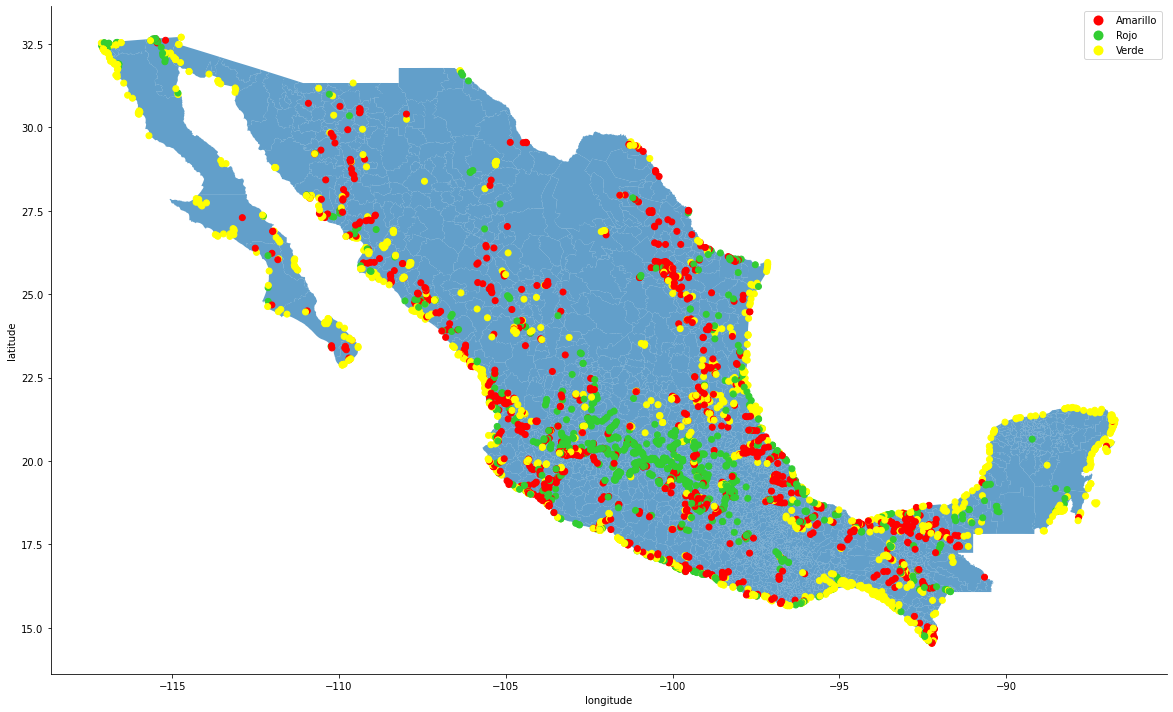

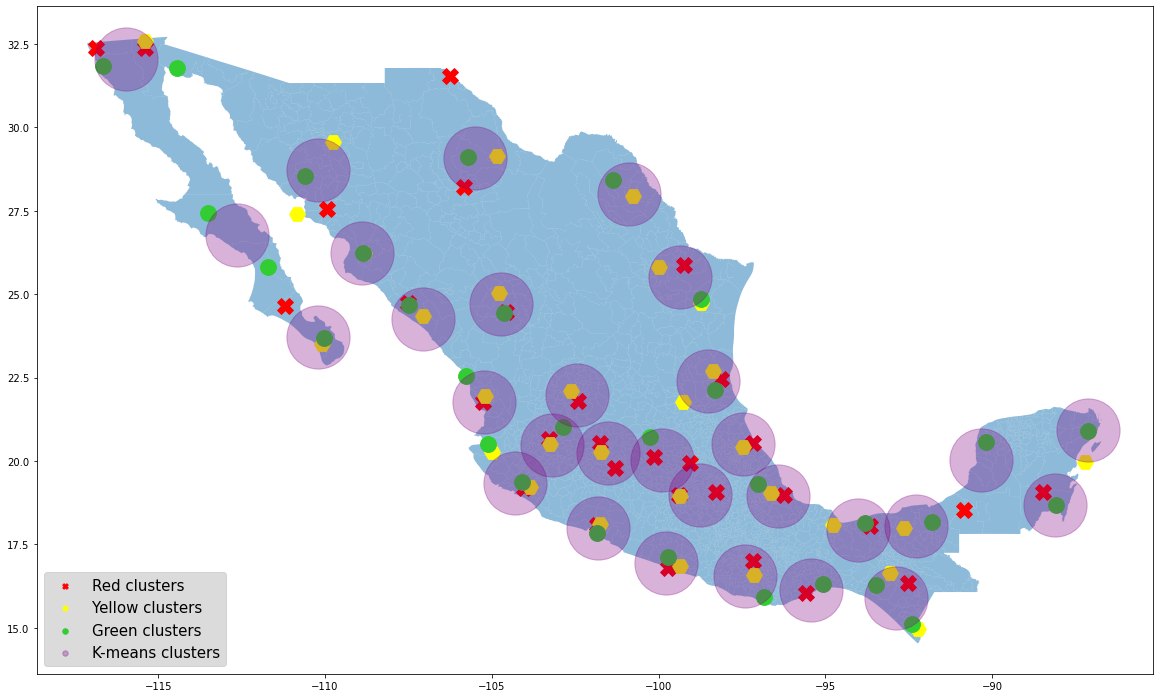

In [ ]:
graphCuerposDeAgua(30, 4000, 30, 30, 30, superficialesLatLon)

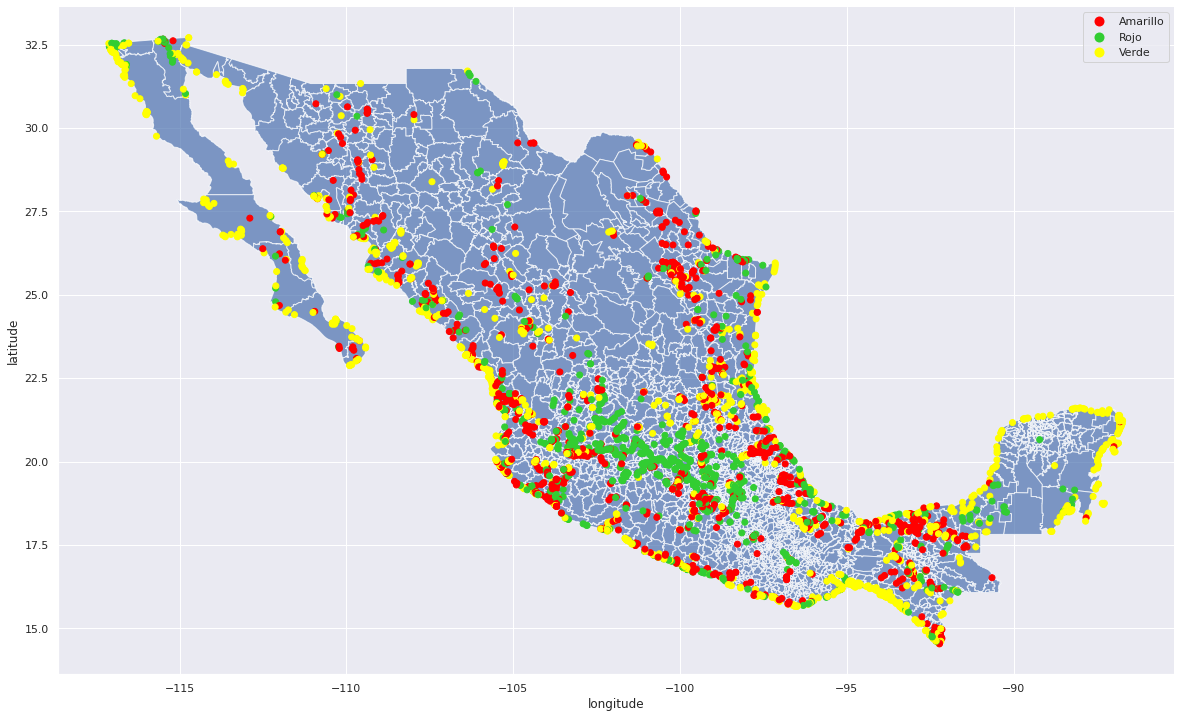

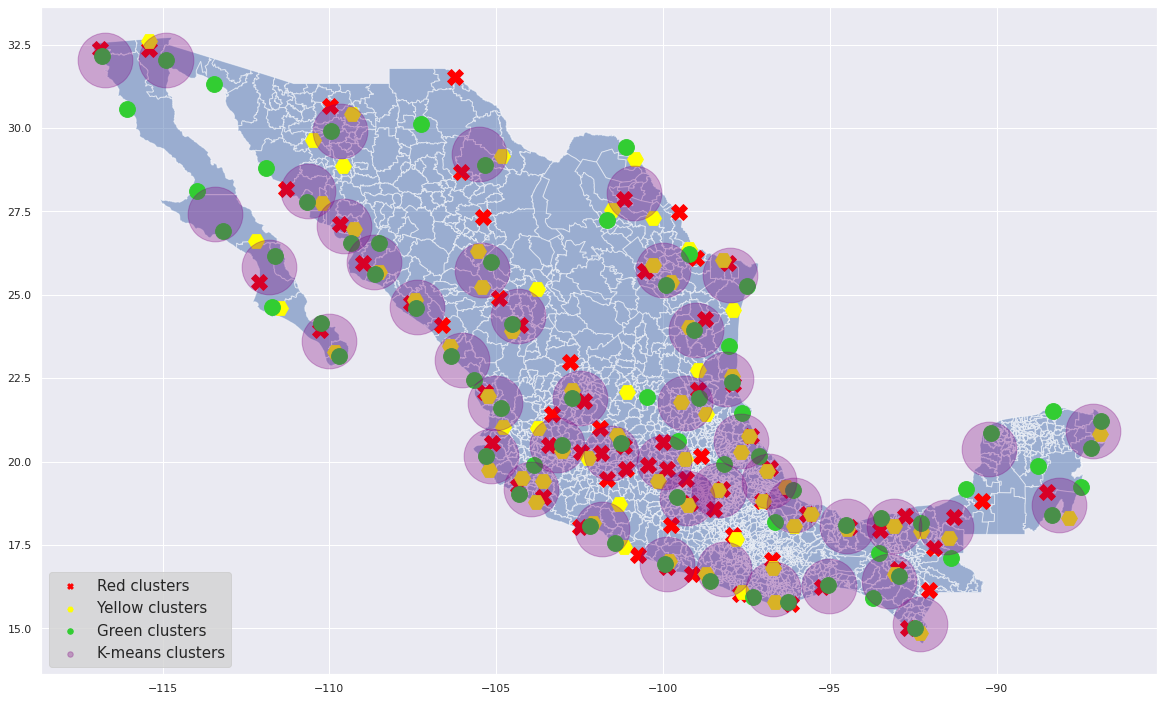

In [ ]:
graphCuerposDeAgua(45, 3000, 70, 70, 70, superficialesLatLon)